In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## install required packages
!pip install gym
!pip install stockstats
!pip install gymnasium
!pip install stable_baselines3
!pip install alpaca_trade_api
!pip install exchange_calendars
!pip install pyfolio
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install --upgrade ipykernel
## install finrl library
!pip install -q condacolab
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

## Preprocessing

In [10]:
import sys
sys.path.append("/content/drive/MyDrive/kubig_financial/finrl")

In [27]:
%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import itertools
import pandas as pd

### Create Folders

from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

TRAIN_START_DATE = '2010-01-04'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

df.sort_values(['date','tic'],ignore_index=True).head()

/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.364529,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,37.747692,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.344015,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.793047,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.110193,8449400,XLK,0


In [29]:
#split data ticker wise
df_XLB = df[df['tic']=='XLB'][['date','tic','close']]
df_XLE = df[df['tic']=='XLE'][['date','tic','close']]
df_XLF = df[df['tic']=='XLF'][['date','tic','close']]
df_XLI = df[df['tic']=='XLI'][['date','tic','close']]
df_XLK = df[df['tic']=='XLK'][['date','tic','close']]
df_XLP = df[df['tic']=='XLP'][['date','tic','close']]
df_XLU = df[df['tic']=='XLU'][['date','tic','close']]
df_XLV = df[df['tic']=='XLV'][['date','tic','close']]
df_XLY = df[df['tic']=='XLY'][['date','tic','close']]

In [30]:
# Dlinear
D = pd.DataFrame({'XLB':df_XLB['close'].values,
                    'XLE':df_XLE['close'].values,
                    'XLF':df_XLF['close'].values,
                    'XLI':df_XLI['close'].values,
                    'XLK':df_XLK['close'].values,
                    'XLP':df_XLP['close'].values,
                    'XLU':df_XLU['close'].values,
                    'XLV':df_XLV['close'].values,
                    'XLY':df_XLY['close'].values},index=df_XLB['date'].values)

D.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
2010-01-04,25.364529,37.747692,9.344015,21.793047,19.110193,18.586601,19.326469,25.110266,25.176529
2010-01-05,25.446533,38.055771,9.515760,21.869987,19.085564,18.593565,19.096390,24.864017,25.268845
2010-01-06,25.878965,38.511505,9.534843,21.916166,18.872038,18.579638,19.208328,25.118216,25.302408
2010-01-07,25.677666,38.453732,9.738386,22.154718,18.798130,18.579638,19.121267,25.205603,25.512205
2010-01-08,26.035532,38.704056,9.681139,22.508707,18.921307,18.516909,19.102606,25.245314,25.503819


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

In [38]:
D = pd.read_csv('/content/drive/MyDrive/kubig_financial/dataset/D.csv')
D.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
D.head()

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,2010-01-04,25.488928,38.080162,9.385947,21.880188,19.150221,18.718464,19.481915,25.213638,25.227169
1,2010-01-05,25.571354,38.390972,9.558456,21.957457,19.125528,18.725483,19.249992,24.966366,25.319664
2,2010-01-06,26.005892,38.850708,9.577625,22.003801,18.911566,18.711449,19.362823,25.221615,25.353292
3,2010-01-07,25.803612,38.792439,9.782079,22.243311,18.837500,18.711449,19.275064,25.309351,25.563526
4,2010-01-08,26.163239,39.044956,9.724579,22.598709,18.960951,18.648277,19.256264,25.349237,25.555117


In [40]:
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-01'

TRAIN_VAL_DATE = '2020-01-03'
TRADE_VAL_DATE = '2023-01-04'

In [41]:
TRAIN_END_INDEX = D[D.date==TRAIN_END_DATE].index[0]
TRADE_START_INDEX = D[D.date==TRAIN_END_DATE].index[0]
TRADE_END_INDEX = D[D.date==TRADE_END_DATE].index[0]

TRAIN_VAL_INDEX = D[D.date==TRAIN_VAL_DATE].index[0]
TRADE_VAL_INDEX = D[D.date==TRADE_VAL_DATE].index[0]

print(TRAIN_END_INDEX)
print(TRADE_END_INDEX)

2957
3353


In [42]:
train_df = D.loc[:TRAIN_END_INDEX]
test_df = D.loc[TRADE_START_INDEX:TRADE_END_INDEX]
test_df.reset_index(drop=True, inplace=True)

In [43]:
test_df.head()

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,2021-10-01,77.827316,50.451199,37.005863,96.721664,149.482285,66.495392,61.087296,124.416832,178.426147
1,2021-10-04,77.488388,51.275818,36.685760,96.195053,146.020630,66.283440,61.928818,122.521217,177.014908
2,2021-10-05,78.175919,51.575668,37.403564,97.267784,148.101547,66.620644,61.775818,123.254059,177.725464
3,2021-10-06,78.030670,51.032177,37.442368,97.696877,149.068054,67.266129,62.732098,123.029320,178.287964
4,2021-10-07,79.047447,51.425747,37.665474,98.457550,150.429031,67.564796,62.397396,124.661110,181.061081


### Preprocessing Code

In [44]:
def standardization(train_df, test_df, not_col):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean = train_df[x].mean()
        std = train_df[x].std()
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list, std_list

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

###DLinear Code

In [45]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

## Execution Code

In [46]:
### parameters
window_size = 72
forcast_size= 1 #5
batch_size = 32
targets = list(D.columns)[1:]
date = 'date'

train_loss_list = []
valid_loss_list = []
test_loss_list = []
dlinear_prediction = []
epoch = 20
lr = 0.001
###############


### 데이터 정규화
train_df_fe, test_df_fe, mean_list, std_list = standardization(train_df, test_df, date)

for tar in targets:
  ### timestep 지정
  train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, tar)
  test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, tar)

  ### DataLoader
  train_ds = Data(train_x[:TRAIN_VAL_INDEX], train_y[:TRAIN_VAL_INDEX])
  valid_ds = Data(train_x[TRADE_VAL_INDEX:], train_y[TRADE_VAL_INDEX:])
  test_ds = Data(test_x, test_y)

  train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
  valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle=False)
  test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)


  ### Dlinear
  DLinear_model = LTSF_DLinear(
      window_size=window_size,
      forcast_size=forcast_size,
      kernel_size=25,
      individual=False,
      feature_size=1,
  )
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
  max_loss = 999999999

  ### training
  for epoch in tqdm(range(1, epoch+1)):

    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    valid_loss = 0
    test_loss = 0
    with torch.no_grad():
      if len(valid_dl) > 0:
          for data, target in valid_dl:
              output = DLinear_model(data)
              valid_loss += criterion(output, target.unsqueeze(-1)).item()
          valid_loss /= len(valid_dl)
          valid_loss_list.append(valid_loss)
      if len(test_dl) > 0:
          for data, target in test_dl:
              output = DLinear_model(data)
              test_loss += criterion(output, target.unsqueeze(-1)).item()
          test_loss /= len(test_dl)
          test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, f'DLinear_model_{tar}.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_loss={:.3f}, Model Saved".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = valid_loss
        dlinear_best_test_loss = test_loss

    print("epoch = {}, train_loss: {:.3f}, valid_loss: {:.3f}, test_loss: {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))


  ### predict
  best_model = torch.load(f"DLinear_model_{tar}.pth")

  # 예측 모드로 설정
  best_model.eval()
  predictions = []

  with torch.no_grad():
      for data, target in test_dl:
          output = best_model(data)
          predictions.append(output.squeeze().tolist())

  pred = list(itertools.chain(*predictions))
  dlinear_prediction.append(pred)

 10%|█         | 2/20 [00:00<00:02,  6.33it/s]

valid_loss=0.000, test_loss=0.041, Model Saved
epoch = 1, train_loss: 0.014, valid_loss: 0.000, test_loss: 0.041
epoch = 2, train_loss: 0.006, valid_loss: 0.000, test_loss: 0.028


 20%|██        | 4/20 [00:00<00:02,  7.95it/s]

epoch = 3, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.020
epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.015


 30%|███       | 6/20 [00:00<00:01,  8.58it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.014
epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.014


 40%|████      | 8/20 [00:00<00:01,  8.86it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010
epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009


 50%|█████     | 10/20 [00:01<00:01,  9.10it/s]

epoch = 9, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 60%|██████    | 12/20 [00:01<00:00,  9.17it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.011
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.013


 70%|███████   | 14/20 [00:01<00:00,  8.88it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 80%|████████  | 16/20 [00:01<00:00,  8.99it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 16, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.011


 90%|█████████ | 18/20 [00:02<00:00,  8.84it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.011


100%|██████████| 20/20 [00:02<00:00,  8.57it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008



 10%|█         | 2/20 [00:00<00:01,  9.41it/s]

valid_loss=0.000, test_loss=0.201, Model Saved
epoch = 1, train_loss: 0.071, valid_loss: 0.000, test_loss: 0.201
epoch = 2, train_loss: 0.026, valid_loss: 0.000, test_loss: 0.133


 20%|██        | 4/20 [00:00<00:01,  8.89it/s]

epoch = 3, train_loss: 0.016, valid_loss: 0.000, test_loss: 0.082
epoch = 4, train_loss: 0.012, valid_loss: 0.000, test_loss: 0.059


 30%|███       | 6/20 [00:00<00:01,  8.85it/s]

epoch = 5, train_loss: 0.010, valid_loss: 0.000, test_loss: 0.049
epoch = 6, train_loss: 0.009, valid_loss: 0.000, test_loss: 0.044


 40%|████      | 8/20 [00:00<00:01,  9.01it/s]

epoch = 7, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.041
epoch = 8, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.039


 50%|█████     | 10/20 [00:01<00:01,  8.92it/s]

epoch = 9, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.045
epoch = 10, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.056


 60%|██████    | 12/20 [00:01<00:00,  9.32it/s]

epoch = 11, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.037
epoch = 12, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.038


 70%|███████   | 14/20 [00:01<00:00,  9.31it/s]

epoch = 13, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.038
epoch = 14, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.037


 80%|████████  | 16/20 [00:01<00:00,  9.19it/s]

epoch = 15, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.036
epoch = 16, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.040


 90%|█████████ | 18/20 [00:01<00:00,  9.46it/s]

epoch = 17, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.053
epoch = 18, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.043


100%|██████████| 20/20 [00:02<00:00,  9.12it/s]

epoch = 19, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.036
epoch = 20, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.040



 10%|█         | 2/20 [00:00<00:02,  8.80it/s]

valid_loss=0.000, test_loss=0.031, Model Saved
epoch = 1, train_loss: 0.016, valid_loss: 0.000, test_loss: 0.031
epoch = 2, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.021


 20%|██        | 4/20 [00:00<00:01,  9.23it/s]

epoch = 3, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.017
epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.016


 30%|███       | 6/20 [00:00<00:01,  9.34it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.012
epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010


 40%|████      | 8/20 [00:00<00:01,  9.49it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008
epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 50%|█████     | 10/20 [00:01<00:01,  9.42it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 60%|██████    | 12/20 [00:01<00:00,  9.09it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 70%|███████   | 14/20 [00:01<00:00,  9.13it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 80%|████████  | 16/20 [00:01<00:00,  9.28it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 90%|█████████ | 18/20 [00:01<00:00,  9.37it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


100%|██████████| 20/20 [00:02<00:00,  9.17it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005



 10%|█         | 2/20 [00:00<00:02,  6.91it/s]

valid_loss=0.000, test_loss=0.024, Model Saved
epoch = 1, train_loss: 0.013, valid_loss: 0.000, test_loss: 0.024
epoch = 2, train_loss: 0.006, valid_loss: 0.000, test_loss: 0.019


 20%|██        | 4/20 [00:00<00:02,  6.66it/s]

epoch = 3, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.012
epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.014


 30%|███       | 6/20 [00:00<00:02,  6.61it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009
epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009


 40%|████      | 8/20 [00:01<00:01,  6.66it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 50%|█████     | 10/20 [00:01<00:01,  6.46it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 60%|██████    | 12/20 [00:01<00:01,  6.61it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 70%|███████   | 14/20 [00:02<00:00,  6.59it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 80%|████████  | 16/20 [00:02<00:00,  6.27it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 90%|█████████ | 18/20 [00:02<00:00,  5.87it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005



 10%|█         | 2/20 [00:00<00:01,  9.52it/s]

valid_loss=0.000, test_loss=0.050, Model Saved
epoch = 1, train_loss: 0.005, valid_loss: 0.000, test_loss: 0.050
epoch = 2, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.035


 20%|██        | 4/20 [00:00<00:01,  9.33it/s]

epoch = 3, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.025
epoch = 4, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.017


 30%|███       | 6/20 [00:00<00:01,  9.50it/s]

epoch = 5, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.016
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.012


 40%|████      | 8/20 [00:00<00:01,  9.22it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.012
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.012


 50%|█████     | 10/20 [00:01<00:01,  9.10it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.010


 60%|██████    | 12/20 [00:01<00:00,  9.22it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 12, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


 70%|███████   | 14/20 [00:01<00:00,  9.26it/s]

epoch = 13, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.009
epoch = 14, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


 80%|████████  | 16/20 [00:01<00:00,  9.07it/s]

epoch = 15, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.009
epoch = 16, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


 90%|█████████ | 18/20 [00:01<00:00,  8.86it/s]

epoch = 17, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008
epoch = 18, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


100%|██████████| 20/20 [00:02<00:00,  9.15it/s]

epoch = 19, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.009
epoch = 20, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008



 10%|█         | 2/20 [00:00<00:02,  8.90it/s]

valid_loss=0.000, test_loss=0.025, Model Saved
epoch = 1, train_loss: 0.012, valid_loss: 0.000, test_loss: 0.025
epoch = 2, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.023


 20%|██        | 4/20 [00:00<00:01,  8.74it/s]

epoch = 3, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.013
epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009


 30%|███       | 6/20 [00:00<00:01,  8.96it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.007
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 40%|████      | 8/20 [00:00<00:01,  9.29it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 50%|█████     | 10/20 [00:01<00:01,  9.48it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 60%|██████    | 12/20 [00:01<00:00,  8.99it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 70%|███████   | 14/20 [00:01<00:00,  9.10it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 80%|████████  | 16/20 [00:01<00:00,  9.20it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 90%|█████████ | 18/20 [00:01<00:00,  9.26it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


100%|██████████| 20/20 [00:02<00:00,  9.12it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004



 10%|█         | 2/20 [00:00<00:01,  9.65it/s]

valid_loss=0.000, test_loss=0.039, Model Saved
epoch = 1, train_loss: 0.013, valid_loss: 0.000, test_loss: 0.039
epoch = 2, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.025


 20%|██        | 4/20 [00:00<00:01,  9.50it/s]

epoch = 3, train_loss: 0.005, valid_loss: 0.000, test_loss: 0.020
epoch = 4, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.015


 30%|███       | 6/20 [00:00<00:01,  8.92it/s]

epoch = 5, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.012
epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010


 40%|████      | 8/20 [00:00<00:01,  9.09it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008
epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 50%|█████     | 10/20 [00:01<00:01,  9.28it/s]

epoch = 9, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009
epoch = 10, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.006


 60%|██████    | 12/20 [00:01<00:00,  9.42it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 12, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.007


 70%|███████   | 14/20 [00:01<00:00,  9.19it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 80%|████████  | 16/20 [00:01<00:00,  8.97it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 90%|█████████ | 18/20 [00:01<00:00,  9.13it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


100%|██████████| 20/20 [00:02<00:00,  9.17it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005



 10%|█         | 2/20 [00:00<00:01,  9.70it/s]

valid_loss=0.000, test_loss=0.022, Model Saved
epoch = 1, train_loss: 0.010, valid_loss: 0.000, test_loss: 0.022
epoch = 2, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.015


 20%|██        | 4/20 [00:00<00:01,  9.58it/s]

epoch = 3, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.011
epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010


 30%|███       | 6/20 [00:00<00:01,  9.51it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.006
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 35%|███▌      | 7/20 [00:00<00:01,  9.55it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 50%|█████     | 10/20 [00:01<00:01,  9.57it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 60%|██████    | 12/20 [00:01<00:00,  9.38it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 70%|███████   | 14/20 [00:01<00:00,  7.86it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 75%|███████▌  | 15/20 [00:01<00:00,  7.41it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 85%|████████▌ | 17/20 [00:02<00:00,  5.22it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 95%|█████████▌| 19/20 [00:02<00:00,  5.85it/s]

epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


100%|██████████| 20/20 [00:02<00:00,  6.81it/s]

epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003



 10%|█         | 2/20 [00:00<00:02,  6.19it/s]

valid_loss=0.000, test_loss=0.044, Model Saved
epoch = 1, train_loss: 0.009, valid_loss: 0.000, test_loss: 0.044
epoch = 2, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.039


 20%|██        | 4/20 [00:00<00:02,  5.79it/s]

epoch = 3, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.027
epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.017


 30%|███       | 6/20 [00:01<00:02,  5.66it/s]

epoch = 5, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.014
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.012


 40%|████      | 8/20 [00:01<00:01,  6.56it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.011
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.010


 50%|█████     | 10/20 [00:01<00:01,  7.85it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.010
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 60%|██████    | 12/20 [00:01<00:00,  8.48it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 70%|███████   | 14/20 [00:01<00:00,  8.89it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 80%|████████  | 16/20 [00:02<00:00,  9.17it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 90%|█████████ | 18/20 [00:02<00:00,  9.19it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


100%|██████████| 20/20 [00:02<00:00,  7.71it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


In [47]:
targets

['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

In [48]:
print(len(dlinear_prediction[0]))
print(len(test_df_fe.iloc[window_size:]))

325
325


In [49]:
len(dlinear_prediction)
test_df_pred = test_df_fe.iloc[window_size:].copy()

for i in range(len(targets)):
  test_df_pred[targets[i]] = dlinear_prediction[i]

test_df_pred.head()

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
72,2022-01-13,3.091761,0.731959,2.764055,2.515931,3.403613,2.369151,2.212967,2.542276,2.933473
73,2022-01-14,3.093307,0.765333,2.775242,2.519682,3.402276,2.373093,2.214875,2.542760,2.933817
74,2022-01-18,3.088059,0.823894,2.779429,2.519828,3.400789,2.377814,2.215056,2.540038,2.928007
75,2022-01-19,3.073481,0.878618,2.776813,2.515908,3.395146,2.377175,2.212847,2.537707,2.918061
76,2022-01-20,3.059651,0.914940,2.765218,2.510227,3.383682,2.379348,2.213132,2.532418,2.902645


In [50]:
### destandardization
def inverse_standardization(test_df, not_col):
    test_df_ = test_df.copy()
    col = [col for col in list(train_df.columns) if col not in [not_col]]

    for x in range(len(targets)):
        mean = mean_list[x]
        std = std_list[x]
        test_df_.iloc[:, x+1] = (test_df_.iloc[:, x+1] * std) + mean

    return test_df_


test_df_pred_ds = inverse_standardization(test_df_pred, date)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


In [51]:
test_df_pred_ds[180:].tail()

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
392,2023-04-25,80.088839,82.503427,32.823126,100.783665,145.256715,73.984921,68.526862,132.773519,143.569420
393,2023-04-26,79.908293,82.556865,32.758140,100.663616,145.170009,74.107905,68.537343,132.790333,143.449930
394,2023-04-27,79.697387,82.429158,32.649999,100.403542,145.074406,74.173164,68.483892,132.701563,143.179108
395,2023-04-28,79.584800,82.382365,32.582408,100.254663,145.162525,74.310872,68.516981,132.644099,143.027199
396,2023-05-01,79.607906,82.526828,32.548521,100.156259,145.494752,74.473373,68.541341,132.607725,143.008742


In [52]:
test_df.tail()

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
392,2023-04-25,79.489998,84.660004,32.570000,98.989998,143.970001,76.779999,69.900002,133.610001,144.429993
393,2023-04-26,78.550003,83.529999,32.259998,97.120003,146.110001,76.180000,68.260002,131.710007,143.690002
394,2023-04-27,79.620003,83.830002,32.779999,99.040001,149.210007,77.029999,69.080002,132.399994,147.479996
395,2023-04-28,80.550003,85.129997,33.169998,100.000000,150.830002,77.440002,68.980003,133.529999,147.860001
396,2023-05-01,80.510002,84.169998,33.080002,100.540001,150.919998,77.500000,69.099998,134.220001,146.399994


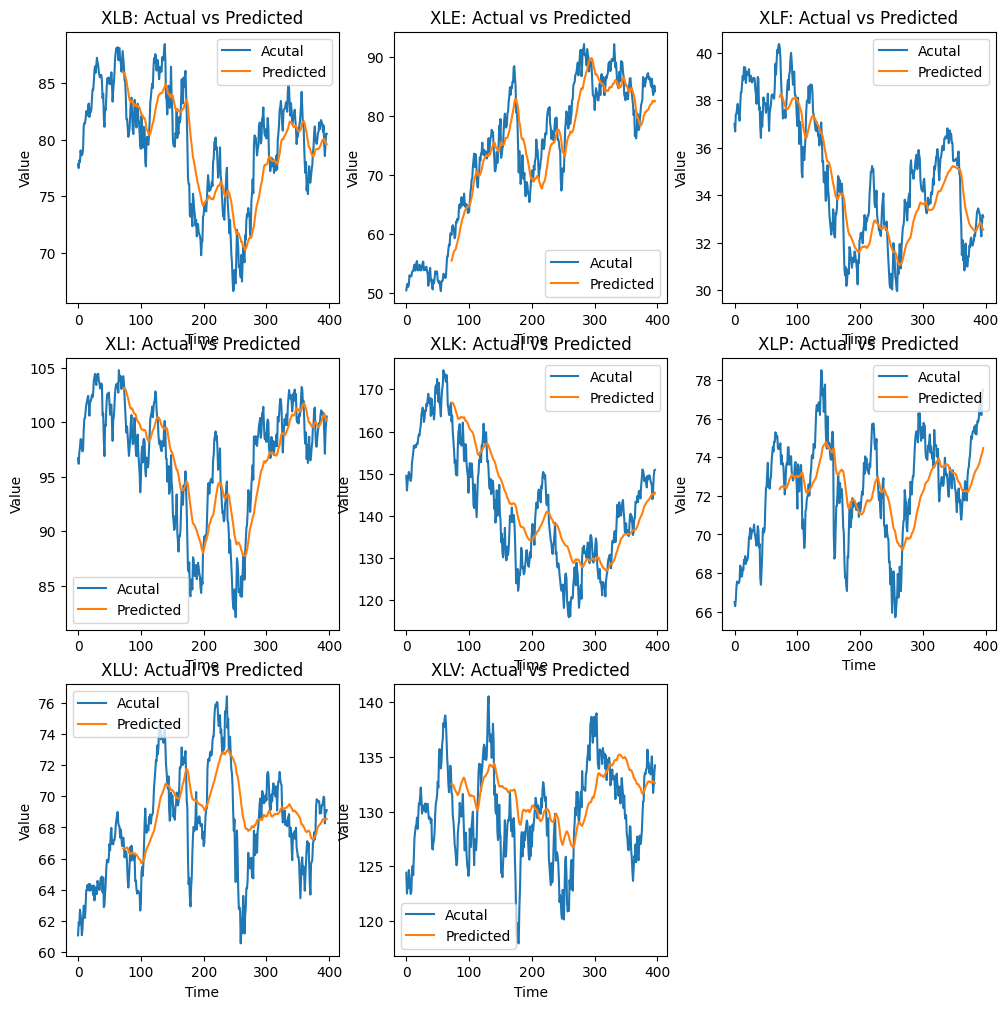

In [53]:
# 그래프 그리기
plt.figure(figsize=(12, 12))
for i in range(len(targets)-1):
  plt.subplot(3,3,i+1)
  plt.plot(test_df[targets[i]], label='Acutal')
  plt.plot(test_df_pred_ds[targets[i]], label='Predicted')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.title(f'{targets[i]}: Actual vs Predicted')
  plt.legend()

In [54]:
test_df_pred_ds.to_csv('/content/drive/MyDrive/kubig_financial/dataset/DLinear.csv')

## Execution Code 2

In [55]:
df_fe = pd.concat([train_df_fe, test_df_fe])
df_fe

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,2010-01-04,-1.257581,-1.282793,-1.212013,-1.441745,-0.959033,-1.577020,-1.379345,-1.334136,-1.305590
1,2010-01-05,-1.251648,-1.246827,-1.188165,-1.437979,-0.959762,-1.576503,-1.397006,-1.343069,-1.303282
2,2010-01-06,-1.220374,-1.193629,-1.185515,-1.435720,-0.966081,-1.577536,-1.388414,-1.333847,-1.302443
3,2010-01-07,-1.234932,-1.200371,-1.157251,-1.424045,-0.968268,-1.577536,-1.395097,-1.330678,-1.297196
4,2010-01-08,-1.209049,-1.171151,-1.165200,-1.406722,-0.964622,-1.582184,-1.396529,-1.329237,-1.297406
...,...,...,...,...,...,...,...,...,...,...
392,2023-04-25,2.628995,4.107227,1.992993,2.316795,2.727173,2.695363,2.460148,2.582160,1.669368
393,2023-04-26,2.561342,3.976468,1.950138,2.225647,2.790372,2.651213,2.335257,2.513514,1.650900
394,2023-04-27,2.638352,4.011183,2.022024,2.319233,2.881922,2.713759,2.397702,2.538443,1.745487
395,2023-04-28,2.705286,4.161613,2.075938,2.366026,2.929764,2.743929,2.390087,2.579269,1.754971


In [56]:
def time_slide_df_ver2(df, window_size, forecast_size, date, target):
    df_ = df.reset_index(drop=True)  # Reset the index to avoid non-unique labels
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


In [57]:
### parameters
window_size = 72
forcast_size= 1
batch_size = 32
targets = list(D.columns)[1:]
date = 'date'

train_loss_list = []
valid_loss_list = []
test_loss_list = []
dlinear_prediction = []
epoch = 20
lr = 0.001
###############

### 데이터 정규화
train_df_fe, test_df_fe, mean_list, std_list = standardization(train_df, test_df, date)
df_fe = pd.concat([train_df_fe, test_df_fe])

for tar in targets:
  ### timestep 지정
  test_x, test_y, test_date = time_slide_df_ver2(df_fe, window_size, forcast_size, date, tar)

  ### DataLoader
  test_ds = Data(test_x, test_y)
  test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)

  ### predict
  best_model = torch.load(f"DLinear_model_{tar}.pth")

  # 예측 모드로 설정
  best_model.eval()
  predictions = []

  with torch.no_grad():
      for data, target in test_dl:
          output = best_model(data)
          predictions.append(output.squeeze().tolist())

  pred = list(itertools.chain(*predictions))
  dlinear_prediction.append(pred)

In [58]:
print(len(dlinear_prediction[0]))
print(len(df_fe.iloc[window_size:]))

3283
3283


In [59]:
len(dlinear_prediction)
df_pred = df_fe.iloc[window_size:].copy()

for i in range(len(targets)):
  df_pred[targets[i]] = dlinear_prediction[i]

df_pred.head()

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
72,2010-04-19,-1.230903,-1.166212,-1.054894,-1.328925,-0.942462,-1.498200,-1.406957,-1.307862,-1.181374
73,2010-04-20,-1.228972,-1.166673,-1.053183,-1.325899,-0.941812,-1.496993,-1.406756,-1.307284,-1.179622
74,2010-04-21,-1.227737,-1.155488,-1.050270,-1.322265,-0.941375,-1.495455,-1.405861,-1.306570,-1.177679
75,2010-04-22,-1.226447,-1.145432,-1.048913,-1.319187,-0.940696,-1.494062,-1.404942,-1.306476,-1.175401
76,2010-04-23,-1.224394,-1.135494,-1.045676,-1.315474,-0.939617,-1.493212,-1.404345,-1.307118,-1.172732


In [60]:
### destandardization
def inverse_standardization(test_df, not_col):
    test_df_ = test_df.copy()
    col = [col for col in list(train_df.columns) if col not in [not_col]]

    for x in range(len(targets)):
        mean = mean_list[x]
        std = std_list[x]
        test_df_.iloc[:, x+1] = (test_df_.iloc[:, x+1] * std) + mean

    return test_df_


df_pred_ds = inverse_standardization(df_pred, date)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


In [61]:
df_pred_ds.to_csv('/content/drive/MyDrive/kubig_financial/dataset/DLinear_prediction.csv')